In [1]:
!pip install yfinance scikit-learn joblib matplotlib


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


In [5]:
import joblib

In [19]:
### Fetch MSFT Stock (Jan 2025 → Nov 14 2025)
ticker = "MSFT"
data = yf.download(ticker, start="2023-01-01", end="2024-11-14")
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2023-01-03,233.985657,240.011582,231.856553,237.403930,25740000
2023-01-04,223.750366,227.432323,220.683688,226.856104,50623400
2023-01-05,217.118881,222.236528,216.581721,221.894695,39585600
2023-01-06,219.677734,220.488355,214.228044,217.792808,43613600
2023-01-09,221.816589,225.840395,221.123177,221.162236,27369800


In [20]:
## Clean Data
data = data[['Open','High','Low','Close','Volume']]
data.dropna(inplace = True)

In [21]:
### Compute z - score
data['Z-score'] = (data['Close'] - data['Close'].mean())/ data['Close'].std()

In [22]:
data

Price,Open,High,Low,Close,Volume,Z-score
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,
Date,,,,,,
2023-01-03,237.403930,240.011582,231.856553,233.985657,25740000,-1.999607
2023-01-04,226.856104,227.432323,220.683688,223.750366,50623400,-2.165238
2023-01-05,221.894695,222.236528,216.581721,217.118881,39585600,-2.272551
2023-01-06,217.792808,220.488355,214.228044,219.677734,43613600,-2.231143
2023-01-09,221.162236,225.840395,221.123177,221.816589,27369800,-2.196531
...,...,...,...,...,...,...
2024-11-07,417.359634,422.877807,415.972668,421.471008,19901800,1.034349
2024-11-08,421.362069,422.531081,417.855003,418.607941,16891400,0.988018


In [23]:
### Assign Risk Classes 
# Z-Score	Risk
# ≤ -1	High Risk
# -1 to 1	Medium Risk
# ≥ 1	Low Risk

In [24]:
def assign_risk(z):
    if z <= -1:
        return 2  # High
    elif z >= 1:
        return 0  # Low
    else:
        return 1  # Medium

data['Risk_Class'] = data['Z-score'].apply(assign_risk)


In [25]:
### Prepare for next day prediction
# Target for next-day prediction
data['Target'] = data['Risk_Class'].shift(-1)

# Remove only last row (not whole dataset)
data = data.iloc[:-1]

X = data[['Open','High','Low','Close','Volume']]
y = data['Target']


In [26]:
## scale and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [33]:
### Training models 
## KNN
knn = KNeighborsClassifier(n_neighbors =5)
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_test)

In [34]:
### Decision Tree
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [35]:
### SVM 
svm = SVC()
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_test)

In [36]:
### Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [37]:
### Compare Model Performance
models ={
    "KNN": knn_pred,
    "Decision Tree": dt_pred,
    "SVM": svm_pred,
    "Random Forest": rf_pred
}
for name, pred in models.items():
    print(f"\n{name} Accuracy:", accuracy_score(y_test,pred))
    print(classification_report(y_test,pred))
    


KNN Accuracy: 0.9148936170212766
              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        14
         1.0       0.92      0.95      0.93        60
         2.0       0.95      1.00      0.98        20

    accuracy                           0.91        94
   macro avg       0.90      0.86      0.88        94
weighted avg       0.91      0.91      0.91        94


Decision Tree Accuracy: 0.925531914893617
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79        14
         1.0       0.95      0.93      0.94        60
         2.0       0.95      1.00      0.98        20

    accuracy                           0.93        94
   macro avg       0.90      0.91      0.90        94
weighted avg       0.93      0.93      0.93        94


SVM Accuracy: 0.9148936170212766
              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        14
         1.0      

In [38]:
### Save best model
joblib.dump(rf, "msft_stock_risk_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [39]:
### Predict Next day risk
latest = X.tail(1)
latest_scaled = scaler.transform(latest)

next_pred = rf.predict(latest_scaled)
risk_map = {0:"Low",1:"Medium",2:"High"}

print("Next Day Predicted Risk:", risk_map[next_pred[0]])


Next Day Predicted Risk: Low


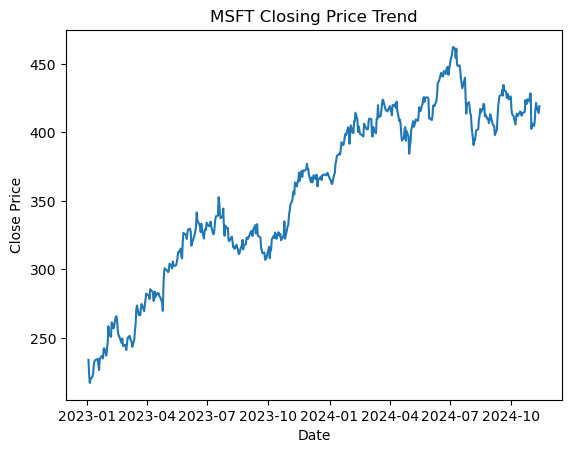

In [47]:
### Visualizations 
####### Closing Price Trend
plt.plot(data.index, data['Close'])
plt.title("MSFT Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


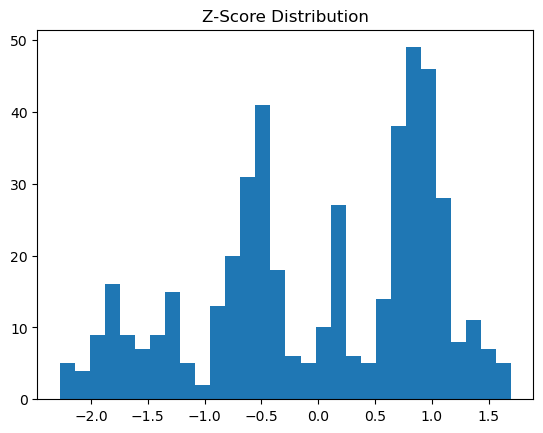

In [42]:
### z- score Histogram
plt.hist(data['Z-score'], bins=30)
plt.title("Z-Score Distribution")
plt.show()


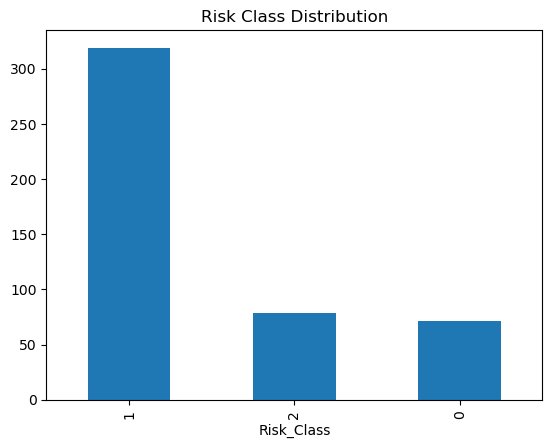

In [44]:
### Risk class count
data['Risk_Class'].value_counts().plot(kind='bar')
plt.title("Risk Class Distribution")
plt.show()

